<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/S5_Norm/EVA3_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Net #Importing `Net` from model.py
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [23]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
loss_all = []
acc_all = []

## Group Normalization


In [25]:
from torchsummary import summary
norm = 'GN' #Using group norm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(norm,num=2).to(device) # Setting number of groups to 2
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
           Dropout-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 10, 12, 12]             320
            Conv2d-7           [-1, 16, 10, 10]           1,440
           Dropout-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           2,304
          Dropout-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 16, 6, 6]           2,304
AdaptiveAvgPool2d-12             [-1, 16, 1, 1]               0
           Linear-13                   [-1, 10]             170
Total params: 11,290
Trainable params: 

In [26]:
import torchvision.transforms.functional as TF

torch.manual_seed(1)
batch_size = 32
loss_arr = []
acc_arr = []
inc = []
pre = []

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100. * correct / len(train_loader.dataset)}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                inc.append(sample)
                pre.append(actual_pred)

    test_loss /= len(test_loader.dataset)
    loss_arr.append(test_loss)
    acc_arr.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)

for epoch in range(20):
    print("Epoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

loss_all.append(loss_arr)
acc_all.append(acc_arr)
loss_arr = []
acc_arr = []

Epoch:  1


loss=0.07028469443321228 batch_id=1874 Train Accuracy=93.79666666666667: 100%|██████████| 1875/1875 [00:41<00:00, 44.92it/s]



Test set: Average loss: 0.0464, Accuracy: 9865/10000 (99%)

Epoch:  2


loss=0.012229216285049915 batch_id=1874 Train Accuracy=97.855: 100%|██████████| 1875/1875 [00:31<00:00, 59.42it/s]



Test set: Average loss: 0.0497, Accuracy: 9841/10000 (98%)

Epoch:  3


loss=0.082585908472538 batch_id=1874 Train Accuracy=98.18833333333333: 100%|██████████| 1875/1875 [00:32<00:00, 57.47it/s]



Test set: Average loss: 0.0338, Accuracy: 9897/10000 (99%)

Epoch:  4


loss=0.004621014464646578 batch_id=1874 Train Accuracy=98.465: 100%|██████████| 1875/1875 [00:31<00:00, 60.11it/s]



Test set: Average loss: 0.0444, Accuracy: 9861/10000 (99%)

Epoch:  5


loss=0.13374373316764832 batch_id=1874 Train Accuracy=98.585: 100%|██████████| 1875/1875 [00:31<00:00, 59.83it/s]



Test set: Average loss: 0.0392, Accuracy: 9880/10000 (99%)

Epoch:  6


loss=0.015665845945477486 batch_id=1874 Train Accuracy=98.82: 100%|██████████| 1875/1875 [00:31<00:00, 58.83it/s]



Test set: Average loss: 0.0445, Accuracy: 9872/10000 (99%)

Epoch:  7


loss=0.029741276055574417 batch_id=1874 Train Accuracy=99.125: 100%|██████████| 1875/1875 [00:31<00:00, 59.14it/s]



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99%)

Epoch:  8


loss=0.0015558624872937799 batch_id=1874 Train Accuracy=99.19166666666666: 100%|██████████| 1875/1875 [00:31<00:00, 59.56it/s]



Test set: Average loss: 0.0281, Accuracy: 9915/10000 (99%)

Epoch:  9


loss=0.03514779359102249 batch_id=1874 Train Accuracy=99.22333333333333: 100%|██████████| 1875/1875 [00:31<00:00, 59.11it/s]



Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99%)

Epoch:  10


loss=0.005341824144124985 batch_id=1874 Train Accuracy=99.24333333333334: 100%|██████████| 1875/1875 [00:31<00:00, 59.56it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99%)

Epoch:  11


loss=0.25163698196411133 batch_id=1874 Train Accuracy=99.24: 100%|██████████| 1875/1875 [00:31<00:00, 58.96it/s]



Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99%)

Epoch:  12


loss=0.018844522535800934 batch_id=1874 Train Accuracy=99.28666666666666: 100%|██████████| 1875/1875 [00:32<00:00, 58.05it/s]



Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99%)

Epoch:  13


loss=0.0006241523078642786 batch_id=1874 Train Accuracy=99.31833333333333: 100%|██████████| 1875/1875 [00:31<00:00, 58.85it/s]



Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99%)

Epoch:  14


loss=0.003600914729759097 batch_id=1874 Train Accuracy=99.34: 100%|██████████| 1875/1875 [00:31<00:00, 58.67it/s]



Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99%)

Epoch:  15


loss=0.010442040860652924 batch_id=1874 Train Accuracy=99.36: 100%|██████████| 1875/1875 [00:31<00:00, 59.87it/s]



Test set: Average loss: 0.0242, Accuracy: 9929/10000 (99%)

Epoch:  16


loss=0.003985395189374685 batch_id=1874 Train Accuracy=99.40333333333334: 100%|██████████| 1875/1875 [00:32<00:00, 57.70it/s]



Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99%)

Epoch:  17


loss=0.003223892068490386 batch_id=1874 Train Accuracy=99.44666666666667: 100%|██████████| 1875/1875 [00:31<00:00, 59.65it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99%)

Epoch:  18


loss=0.2033565789461136 batch_id=1874 Train Accuracy=99.37833333333333: 100%|██████████| 1875/1875 [00:31<00:00, 59.82it/s]



Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99%)

Epoch:  19


loss=0.0016819620504975319 batch_id=1874 Train Accuracy=99.42833333333333: 100%|██████████| 1875/1875 [00:31<00:00, 59.67it/s]



Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99%)

Epoch:  20


loss=0.02789851650595665 batch_id=1874 Train Accuracy=99.455: 100%|██████████| 1875/1875 [00:31<00:00, 60.35it/s]



Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99%)



In [28]:
plot_arr = []
for i in range(len(inc)):
  plot_arr.append(inc[i].cpu().data.numpy()[0])

Text(0.5, 1.0, '9')

<Figure size 720x720 with 0 Axes>

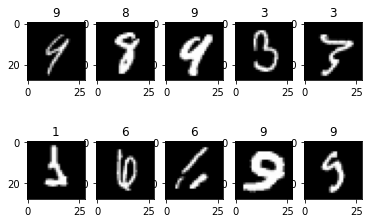

In [29]:
plt.figure(figsize =(10, 10))

# Subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5) 

# Plotting each image as a subplot with the actual target as label
axarr[0,0].imshow(plot_arr[0],cmap='gray')
axarr[0, 0].set_title(pre[0].cpu().item())
axarr[0,1].imshow(plot_arr[1],cmap='gray')
axarr[0, 1].set_title(pre[1].cpu().item())
axarr[0,2].imshow(plot_arr[2],cmap='gray')
axarr[0, 2].set_title(pre[2].cpu().item())
axarr[0,3].imshow(plot_arr[3],cmap='gray')
axarr[0, 3].set_title(pre[3].cpu().item())
axarr[0,4].imshow(plot_arr[4],cmap='gray')
axarr[0, 4].set_title(pre[4].cpu().item())
axarr[1,0].imshow(plot_arr[5],cmap='gray')
axarr[1, 0].set_title(pre[5].cpu().item())
axarr[1,1].imshow(plot_arr[6],cmap='gray')
axarr[1, 1].set_title(pre[6].cpu().item())
axarr[1,2].imshow(plot_arr[7],cmap='gray')
axarr[1, 2].set_title(pre[7].cpu().item())
axarr[1,3].imshow(plot_arr[8],cmap='gray')
axarr[1, 3].set_title(pre[8].cpu().item())
axarr[1,4].imshow(plot_arr[9],cmap='gray')
axarr[1, 4].set_title(pre[9].cpu().item())

In [30]:
inc = []
pre = []
plot_arr = []

## Layer Normalization

In [31]:
from torchsummary import summary
norm = 'LN' # Using layer norm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelln = Net(norm).to(device)
summary(modelln, input_size=(1, 28, 28))

torch.manual_seed(1)
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
           Dropout-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 10, 12, 12]             320
            Conv2d-7           [-1, 16, 10, 10]           1,440
           Dropout-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           2,304
          Dropout-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 16, 6, 6]           2,304
AdaptiveAvgPool2d-12             [-1, 16, 1, 1]               0
           Linear-13                   [-1, 10]             170
Total params: 11,290
Trainable params: 

In [32]:
optimizer = optim.SGD(modelln.parameters(), lr=0.05, momentum=0.9)
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)

for epoch in range(20):
    print("Epoch: ",epoch+1)
    train(modelln, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(modelln, device, test_loader)

loss_all.append(loss_arr)
acc_all.append(acc_arr)
loss_arr = []
acc_arr = []

Epoch:  1


loss=0.09019153565168381 batch_id=1874 Train Accuracy=92.42: 100%|██████████| 1875/1875 [00:37<00:00, 50.02it/s]



Test set: Average loss: 0.0621, Accuracy: 9802/10000 (98%)

Epoch:  2


loss=0.0033083881717175245 batch_id=1874 Train Accuracy=97.36166666666666: 100%|██████████| 1875/1875 [00:31<00:00, 59.19it/s]



Test set: Average loss: 0.0471, Accuracy: 9837/10000 (98%)

Epoch:  3


loss=0.21561361849308014 batch_id=1874 Train Accuracy=97.86: 100%|██████████| 1875/1875 [00:31<00:00, 58.92it/s]



Test set: Average loss: 0.0449, Accuracy: 9864/10000 (99%)

Epoch:  4


loss=0.023219576105475426 batch_id=1874 Train Accuracy=98.34666666666666: 100%|██████████| 1875/1875 [00:30<00:00, 60.52it/s]



Test set: Average loss: 0.0421, Accuracy: 9867/10000 (99%)

Epoch:  5


loss=0.1278568059206009 batch_id=1874 Train Accuracy=98.49333333333334: 100%|██████████| 1875/1875 [00:30<00:00, 60.99it/s]



Test set: Average loss: 0.0448, Accuracy: 9862/10000 (99%)

Epoch:  6


loss=0.030220087617635727 batch_id=1874 Train Accuracy=98.55333333333333: 100%|██████████| 1875/1875 [00:31<00:00, 58.78it/s]



Test set: Average loss: 0.0319, Accuracy: 9904/10000 (99%)

Epoch:  7


loss=0.01796981319785118 batch_id=1874 Train Accuracy=99.01333333333334: 100%|██████████| 1875/1875 [00:31<00:00, 59.93it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99%)

Epoch:  8


loss=0.0011324819643050432 batch_id=1874 Train Accuracy=99.16166666666666: 100%|██████████| 1875/1875 [00:30<00:00, 60.92it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99%)

Epoch:  9


loss=0.018199052661657333 batch_id=1874 Train Accuracy=99.155: 100%|██████████| 1875/1875 [00:30<00:00, 61.03it/s]



Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99%)

Epoch:  10


loss=0.0008343197405338287 batch_id=1874 Train Accuracy=99.15166666666667: 100%|██████████| 1875/1875 [00:30<00:00, 60.55it/s]



Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99%)

Epoch:  11


loss=0.27750760316848755 batch_id=1874 Train Accuracy=99.16: 100%|██████████| 1875/1875 [00:30<00:00, 61.02it/s]



Test set: Average loss: 0.0219, Accuracy: 9927/10000 (99%)

Epoch:  12


loss=0.010000897571444511 batch_id=1874 Train Accuracy=99.17666666666666: 100%|██████████| 1875/1875 [00:30<00:00, 61.07it/s]



Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99%)

Epoch:  13


loss=0.0036691492423415184 batch_id=1874 Train Accuracy=99.325: 100%|██████████| 1875/1875 [00:31<00:00, 59.98it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99%)

Epoch:  14


loss=0.002109672175720334 batch_id=1874 Train Accuracy=99.30833333333334: 100%|██████████| 1875/1875 [00:30<00:00, 61.42it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99%)

Epoch:  15


loss=0.0007559948717243969 batch_id=1874 Train Accuracy=99.34833333333333: 100%|██████████| 1875/1875 [00:30<00:00, 60.64it/s]



Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99%)

Epoch:  16


loss=0.012273348867893219 batch_id=1874 Train Accuracy=99.26666666666667: 100%|██████████| 1875/1875 [00:30<00:00, 60.79it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99%)

Epoch:  17


loss=0.01415304746478796 batch_id=1874 Train Accuracy=99.335: 100%|██████████| 1875/1875 [00:30<00:00, 61.54it/s]



Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99%)

Epoch:  18


loss=0.06523866951465607 batch_id=1874 Train Accuracy=99.34833333333333: 100%|██████████| 1875/1875 [00:30<00:00, 60.76it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99%)

Epoch:  19


loss=0.0012444838648661971 batch_id=1874 Train Accuracy=99.37666666666667: 100%|██████████| 1875/1875 [00:30<00:00, 61.19it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99%)

Epoch:  20


loss=0.012300614267587662 batch_id=1874 Train Accuracy=99.395: 100%|██████████| 1875/1875 [00:31<00:00, 59.56it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99%)



Text(0.5, 1.0, '6')

<Figure size 720x720 with 0 Axes>

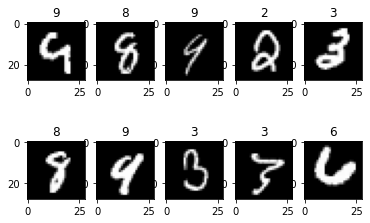

In [33]:
plot_arr = []
for i in range(len(inc)):
  plot_arr.append(inc[i].cpu().data.numpy()[0])


plt.figure(figsize =(10, 10))

# Subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5) 

# Plotting each image as a subplot with the actual target as label
axarr[0,0].imshow(plot_arr[0],cmap='gray')
axarr[0, 0].set_title(pre[0].cpu().item())
axarr[0,1].imshow(plot_arr[1],cmap='gray')
axarr[0, 1].set_title(pre[1].cpu().item())
axarr[0,2].imshow(plot_arr[2],cmap='gray')
axarr[0, 2].set_title(pre[2].cpu().item())
axarr[0,3].imshow(plot_arr[3],cmap='gray')
axarr[0, 3].set_title(pre[3].cpu().item())
axarr[0,4].imshow(plot_arr[4],cmap='gray')
axarr[0, 4].set_title(pre[4].cpu().item())
axarr[1,0].imshow(plot_arr[5],cmap='gray')
axarr[1, 0].set_title(pre[5].cpu().item())
axarr[1,1].imshow(plot_arr[6],cmap='gray')
axarr[1, 1].set_title(pre[6].cpu().item())
axarr[1,2].imshow(plot_arr[7],cmap='gray')
axarr[1, 2].set_title(pre[7].cpu().item())
axarr[1,3].imshow(plot_arr[8],cmap='gray')
axarr[1, 3].set_title(pre[8].cpu().item())
axarr[1,4].imshow(plot_arr[9],cmap='gray')
axarr[1, 4].set_title(pre[9].cpu().item())

In [34]:
inc = []
pre = []
plot_arr = []

## BatchNorm + L1

In [35]:
from torchsummary import summary
norm = 'BN' #Using Batch Norm + L1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelbn = Net(norm).to(device)
summary(modelbn, input_size=(1, 28, 28))

torch.manual_seed(1)
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.RandomRotation((-1.0, 1.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
           Dropout-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 10, 12, 12]             320
            Conv2d-7           [-1, 16, 10, 10]           1,440
           Dropout-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           2,304
          Dropout-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 16, 6, 6]           2,304
AdaptiveAvgPool2d-12             [-1, 16, 1, 1]               0
           Linear-13                   [-1, 10]             170
Total params: 11,290
Trainable params: 

In [36]:
# Function to implement L1 regularization

def trainL1(model, device, train_loader, optimizer, epoch, lambda_l1):
    model.train()
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        l1=0

        # L1 Norm
        for p in model.parameters():
          l1+=p.abs().sum()

        loss += lambda_l1*l1
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100. * correct / len(train_loader.dataset)}')

In [37]:
optimizer = optim.SGD(modelbn.parameters(), lr=0.05, momentum=0.9)
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)

for epoch in range(20):
    print("Epoch: ",epoch+1)
    trainL1(modelbn, device, train_loader, optimizer, epoch, 0.005)
    scheduler.step()
    test(modelbn, device, test_loader)

loss_all.append(loss_arr)
acc_all.append(acc_arr)
loss_arr = []
acc_arr = []

Epoch:  1


loss=1.627228856086731 batch_id=1874 Train Accuracy=85.5: 100%|██████████| 1875/1875 [00:34<00:00, 53.83it/s]



Test set: Average loss: 0.3038, Accuracy: 9168/10000 (92%)

Epoch:  2


loss=1.671357274055481 batch_id=1874 Train Accuracy=87.23833333333333: 100%|██████████| 1875/1875 [00:34<00:00, 54.47it/s]



Test set: Average loss: 0.3378, Accuracy: 9052/10000 (91%)

Epoch:  3


loss=1.737754464149475 batch_id=1874 Train Accuracy=87.09: 100%|██████████| 1875/1875 [00:34<00:00, 54.87it/s]



Test set: Average loss: 0.3225, Accuracy: 9036/10000 (90%)

Epoch:  4


loss=1.7662421464920044 batch_id=1874 Train Accuracy=87.08666666666667: 100%|██████████| 1875/1875 [00:33<00:00, 55.27it/s]



Test set: Average loss: 0.3300, Accuracy: 8971/10000 (90%)

Epoch:  5


loss=1.8468443155288696 batch_id=1874 Train Accuracy=87.79166666666667: 100%|██████████| 1875/1875 [00:34<00:00, 54.56it/s]



Test set: Average loss: 0.2936, Accuracy: 9156/10000 (92%)

Epoch:  6


loss=1.562086582183838 batch_id=1874 Train Accuracy=87.91833333333334: 100%|██████████| 1875/1875 [00:34<00:00, 55.10it/s]



Test set: Average loss: 0.3074, Accuracy: 9088/10000 (91%)

Epoch:  7


loss=1.113417387008667 batch_id=1874 Train Accuracy=91.40166666666667: 100%|██████████| 1875/1875 [00:35<00:00, 52.60it/s]



Test set: Average loss: 0.2327, Accuracy: 9312/10000 (93%)

Epoch:  8


loss=1.1542775630950928 batch_id=1874 Train Accuracy=91.485: 100%|██████████| 1875/1875 [00:34<00:00, 53.76it/s]



Test set: Average loss: 0.1934, Accuracy: 9451/10000 (95%)

Epoch:  9


loss=1.1955879926681519 batch_id=1874 Train Accuracy=91.67833333333333: 100%|██████████| 1875/1875 [00:35<00:00, 53.53it/s]



Test set: Average loss: 0.2230, Accuracy: 9380/10000 (94%)

Epoch:  10


loss=1.2594224214553833 batch_id=1874 Train Accuracy=91.60333333333334: 100%|██████████| 1875/1875 [00:34<00:00, 53.73it/s]



Test set: Average loss: 0.2836, Accuracy: 9188/10000 (92%)

Epoch:  11


loss=1.3506933450698853 batch_id=1874 Train Accuracy=91.72166666666666: 100%|██████████| 1875/1875 [00:35<00:00, 53.24it/s]



Test set: Average loss: 0.2045, Accuracy: 9395/10000 (94%)

Epoch:  12


loss=1.4205693006515503 batch_id=1874 Train Accuracy=91.65666666666667: 100%|██████████| 1875/1875 [00:35<00:00, 53.28it/s]



Test set: Average loss: 0.2109, Accuracy: 9413/10000 (94%)

Epoch:  13


loss=0.8606600761413574 batch_id=1874 Train Accuracy=93.80833333333334: 100%|██████████| 1875/1875 [00:35<00:00, 52.91it/s]



Test set: Average loss: 0.1866, Accuracy: 9471/10000 (95%)

Epoch:  14


loss=0.8874110579490662 batch_id=1874 Train Accuracy=93.71833333333333: 100%|██████████| 1875/1875 [00:36<00:00, 51.65it/s]



Test set: Average loss: 0.1606, Accuracy: 9524/10000 (95%)

Epoch:  15


loss=0.8018659353256226 batch_id=1874 Train Accuracy=93.87666666666667: 100%|██████████| 1875/1875 [00:36<00:00, 51.98it/s]



Test set: Average loss: 0.1712, Accuracy: 9542/10000 (95%)

Epoch:  16


loss=0.9269380569458008 batch_id=1874 Train Accuracy=93.805: 100%|██████████| 1875/1875 [00:36<00:00, 51.29it/s]



Test set: Average loss: 0.1550, Accuracy: 9588/10000 (96%)

Epoch:  17


loss=0.8713110685348511 batch_id=1874 Train Accuracy=93.87333333333333: 100%|██████████| 1875/1875 [00:36<00:00, 51.10it/s]



Test set: Average loss: 0.1491, Accuracy: 9603/10000 (96%)

Epoch:  18


loss=0.9959536790847778 batch_id=1874 Train Accuracy=94.03: 100%|██████████| 1875/1875 [00:36<00:00, 51.65it/s]



Test set: Average loss: 0.1667, Accuracy: 9540/10000 (95%)

Epoch:  19


loss=0.6653012037277222 batch_id=1874 Train Accuracy=95.42666666666666: 100%|██████████| 1875/1875 [00:37<00:00, 50.55it/s]



Test set: Average loss: 0.1026, Accuracy: 9731/10000 (97%)

Epoch:  20


loss=0.7105563282966614 batch_id=1874 Train Accuracy=95.19666666666667: 100%|██████████| 1875/1875 [00:36<00:00, 51.64it/s]



Test set: Average loss: 0.1080, Accuracy: 9725/10000 (97%)



<Figure size 720x720 with 0 Axes>

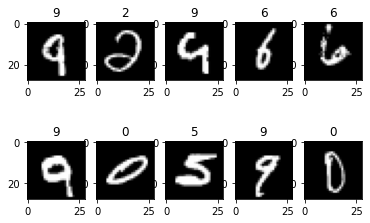

In [38]:
plot_arr = []
for i in range(len(inc)):
  plot_arr.append(inc[i].cpu().data.numpy()[0])



plt.figure(figsize =(10, 10))

# Subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5) 

# Plotting each image as a subplot with the actual target as label
axarr[0,0].imshow(plot_arr[0],cmap='gray')
axarr[0, 0].set_title(pre[0].cpu().item())
axarr[0,1].imshow(plot_arr[1],cmap='gray')
axarr[0, 1].set_title(pre[1].cpu().item())
axarr[0,2].imshow(plot_arr[2],cmap='gray')
axarr[0, 2].set_title(pre[2].cpu().item())
axarr[0,3].imshow(plot_arr[3],cmap='gray')
axarr[0, 3].set_title(pre[3].cpu().item())
axarr[0,4].imshow(plot_arr[4],cmap='gray')
axarr[0, 4].set_title(pre[4].cpu().item())
axarr[1,0].imshow(plot_arr[5],cmap='gray')
axarr[1, 0].set_title(pre[5].cpu().item())
axarr[1,1].imshow(plot_arr[6],cmap='gray')
axarr[1, 1].set_title(pre[6].cpu().item())
axarr[1,2].imshow(plot_arr[7],cmap='gray')
axarr[1, 2].set_title(pre[7].cpu().item())
axarr[1,3].imshow(plot_arr[8],cmap='gray')
axarr[1, 3].set_title(pre[8].cpu().item())
axarr[1,4].imshow(plot_arr[9],cmap='gray')
axarr[1, 4].set_title(pre[9].cpu().item())



inc = []
pre = []
plot_arr = []

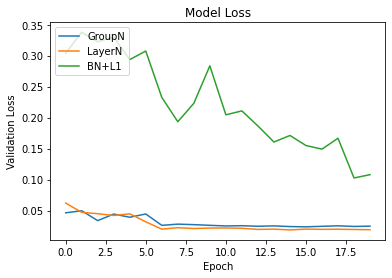

In [39]:
# Plotting Loss 
plt.plot(loss_all[0])
plt.plot(loss_all[1])
plt.plot(loss_all[2])
plt.title('Model Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['GroupN','LayerN','BN+L1'], loc='upper left')
plt.show()

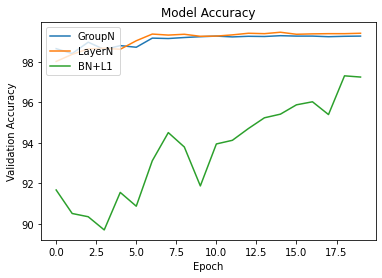

In [40]:
# Plotting Loss 
plt.plot(acc_all[0])
plt.plot(acc_all[1])
plt.plot(acc_all[2])
plt.title('Model Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['GroupN','LayerN','BN+L1'], loc='upper left')
plt.show()